# Import all the Libraries

In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
import itertools

import warnings
warnings.filterwarnings('ignore')

from torch.utils.tensorboard import SummaryWriter
torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

In [2]:
print(torch.__version__)
print(torchvision.__version__)

1.9.0
0.2.2


# Function to print the correct number of predictions

In [3]:
def get_num_correct(preds,labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

# The output size formula is given by 
    if its n x n input
    O = (n-f+2p/s)+1 
    
    if its non square 
    Oh = nh-fh+2p/s +1
    Ow = nw-fw+2p/s+1
    
   n -> input size
   
   p -> padding
   
   s -> stride length
   
   f -> filter size
    
    
        

# Define the  Convolutional Neural Network

In [4]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6,kernel_size=5)
        self.batch_norm_1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.batch_norm_2 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out= nn.Linear(in_features=60, out_features=10)
        
        
        
        
    def forward(self,t):
        #input layer
        t=t
        
        #hidden conv layer
        t=self.conv1(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size=2, stride=2)
        t=self.batch_norm_1(t)
        
        #hidden conv layer
        t=self.conv2(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size=2, stride=2)
        
        #hidden linear layer
        t=t.reshape(-1,12*4*4)
        t=self.fc1(t)
        t=F.relu(t)
        t=self.batch_norm_2(t)
        
        #hidden linear layer
        t=self.fc2(t)
        t=F.relu(t)
        
        #output layer
        t=self.out(t)
        #t=F.softmax(t,dim=1) 
        #no need of this line since loss function will perform the softmax operation
        return t

# Import the Dataset

In [5]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST'
    ,train=True 
    ,download=True
    ,transform=transforms.Compose([transforms.ToTensor()])
)

In [6]:
train_loader_normal = torch.utils.data.DataLoader(train_set,batch_size=len(train_set),
                                               num_workers=1)
data = next(iter(train_loader_normal))
mean = data[0].mean()
std = data[0].std()
print(mean.item())
print(std.item())

0.28604060411453247
0.3530242443084717


In [7]:
train_set_normal = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST'
    ,train=True 
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
        ,transforms.Normalize((mean.item(),), (std.item(),))
    ])
)
print(train_set_normal)

Dataset FashionMNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./data/FashionMNIST
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.28604060411453247,), std=(0.3530242443084717,))
                         )
    Target Transforms (if any): None


In [8]:
train_loader_normal_2 = torch.utils.data.DataLoader(train_set_normal,batch_size=len(train_set),
                                               num_workers=1)
data = next(iter(train_loader_normal_2))
mean = data[0].mean()
std = data[0].std()
print("mean",mean.item(),"\t","std",std.item())

mean -2.910588037252637e-08 	 std 1.0


# Check if GPU is available

In [9]:
print(torch.cuda.is_available())

True


# Run Builder class Implementation

In [10]:
from collections import OrderedDict
from collections import namedtuple
from itertools import product
import time

class RunBuilder():
    @staticmethod
    def get_runs(params):
        Run = namedtuple('Run', params.keys())
        
        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))
            
        return runs
    
trainsets = {'not_normal': train_set,'normal': train_set_normal}

params = OrderedDict(
    lr = [0.01]
    ,batch_size = [1000]
    ,device = ['cuda']
    ,num_workers = [16]
    ,trainset = ['normal']
)



runs = RunBuilder.get_runs(params)
print(runs)

[Run(lr=0.01, batch_size=1000, device='cuda', num_workers=16, trainset='normal')]


# Training Loop

In [11]:
for run in RunBuilder.get_runs(params):
    print(f'{run}')
    
    device = torch.device(run.device)
    network = Network().to(device)

    train_loader = torch.utils.data.DataLoader(trainsets[run.trainset],batch_size=run.batch_size,
                                               num_workers=run.num_workers)
    optimizer = optim.Adam(network.parameters(), lr=run.lr)

    images, labels = next(iter(train_loader))
    grid = torchvision.utils.make_grid(images)

    comment = f'-{run}'
    tb = SummaryWriter(comment=comment)
    tb.add_image('images', grid)
    tb.add_graph(network, images.to(getattr(run,'device','cpu')))

    for epoch in range(20):
        
        epoch_start = time.time()
        total_loss = 0
        total_correct = 0

        for batch in train_loader:
            images = batch[0].to(device)
            labels = batch[1].to(device)
            
            preds = network(images)
            loss = F.cross_entropy(preds, labels)

            optimizer.zero_grad()
            loss.backward() #calculate gradients
            optimizer.step() #Update weights


            total_loss+=loss.item() * run.batch_size
            total_correct+=get_num_correct(preds, labels)

        tb.add_scalar('Loss',total_loss, epoch)
        tb.add_scalar('Number Correct', total_correct, epoch)
        tb.add_scalar('Accuracy', total_correct/len(train_set), epoch)

        for name, weight in network.named_parameters():
            tb.add_histogram(name,weight,epoch)
            tb.add_histogram(f'{name}.grad',weight.grad,epoch)
        epoch_end = time.time()
        epoch_duration = epoch_end - epoch_start

        print("epoch",epoch,"\n","total_correct:",total_correct,"\n","loss:",
              total_loss,"\n","accuracy:",total_correct/len(train_set),
              "\n",'Duration',epoch_duration,"\n",'Device =',run.device,"\n")

    tb.close()


Run(lr=0.01, batch_size=1000, device='cuda', num_workers=16, trainset='normal')
epoch 0 
 total_correct: 47393 
 loss: 34619.163781404495 
 accuracy: 0.7898833333333334 
 Duration 1.514817714691162 
 Device = cuda 

epoch 1 
 total_correct: 52254 
 loss: 20722.450017929077 
 accuracy: 0.8709 
 Duration 1.5457768440246582 
 Device = cuda 

epoch 2 
 total_correct: 53172 
 loss: 18196.86058163643 
 accuracy: 0.8862 
 Duration 1.4904193878173828 
 Device = cuda 

epoch 3 
 total_correct: 53614 
 loss: 16977.548986673355 
 accuracy: 0.8935666666666666 
 Duration 1.532029628753662 
 Device = cuda 

epoch 4 
 total_correct: 53958 
 loss: 15968.62517297268 
 accuracy: 0.8993 
 Duration 1.5131056308746338 
 Device = cuda 

epoch 5 
 total_correct: 54341 
 loss: 15118.936017155647 
 accuracy: 0.9056833333333333 
 Duration 1.5159950256347656 
 Device = cuda 

epoch 6 
 total_correct: 54459 
 loss: 14650.513112545013 
 accuracy: 0.90765 
 Duration 1.6037158966064453 
 Device = cuda 

epoch 7 
 to

# Building Confusion Matrix

In [12]:
def get_all_preds(model,loader):
    all_preds = torch.tensor([]).to(torch.device('cuda'))
    for batch in loader:
        images = batch[0].to(torch.device('cuda'))
        labels = batch[1].to(torch.device('cuda'))
        
        preds = model(images)
        all_preds = torch.cat(
            (all_preds,preds),dim=0)
        
    return all_preds

In [13]:
train_loader = torch.utils.data.DataLoader(train_set_normal,batch_size=1000,
                                               num_workers=16)
with torch.no_grad():
    train_preds = get_all_preds(network, train_loader)

In [14]:
preds_correct = get_num_correct(train_preds, train_set.targets.to(torch.device('cuda')))

print('Total Correct:', preds_correct)
print('Accuracy', preds_correct / len(train_set))

Total Correct: 56343
Accuracy 0.93905


In [15]:
stacked = torch.stack(
    (
        train_set.targets.to(torch.device('cuda')),
        train_preds.argmax(dim=1)
    )
    ,dim=1
)

In [16]:
cmt = torch.zeros(10,10, dtype=torch.int32)


for p in stacked:
    j, k =p.tolist()
    cmt[j,k] = cmt[j,k] +1

print(cmt)

tensor([[5414,    1,   79,   56,    8,    2,  432,    0,    8,    0],
        [  10, 5932,    3,   34,    7,    0,   14,    0,    0,    0],
        [  41,    1, 5565,   24,  197,    0,  171,    0,    1,    0],
        [  65,    7,   11, 5671,  182,    0,   60,    0,    4,    0],
        [   6,    2,  290,   62, 5441,    0,  199,    0,    0,    0],
        [   0,    1,    0,    0,    0, 5959,    0,   21,    0,   19],
        [ 459,    0,  382,   68,  292,    0, 4796,    0,    3,    0],
        [   0,    0,    0,    0,    1,   41,    0, 5700,    5,  253],
        [  11,    3,   11,    7,   19,    1,   19,    1, 5926,    2],
        [   0,    0,    0,    0,    1,    6,    0,   53,    1, 5939]], dtype=torch.int32)


# Plotting the confusion matrix

In [17]:
# Run this cell only when tensors are on CPU

# cm = confusion_matrix(train_set.targets, train_preds.argmax(dim=1))
# print(type(cm))
# cm

In [18]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
tensor([[5414,    1,   79,   56,    8,    2,  432,    0,    8,    0],
        [  10, 5932,    3,   34,    7,    0,   14,    0,    0,    0],
        [  41,    1, 5565,   24,  197,    0,  171,    0,    1,    0],
        [  65,    7,   11, 5671,  182,    0,   60,    0,    4,    0],
        [   6,    2,  290,   62, 5441,    0,  199,    0,    0,    0],
        [   0,    1,    0,    0,    0, 5959,    0,   21,    0,   19],
        [ 459,    0,  382,   68,  292,    0, 4796,    0,    3,    0],
        [   0,    0,    0,    0,    1,   41,    0, 5700,    5,  253],
        [  11,    3,   11,    7,   19,    1,   19,    1, 5926,    2],
        [   0,    0,    0,    0,    1,    6,    0,   53,    1, 5939]], dtype=torch.int32)


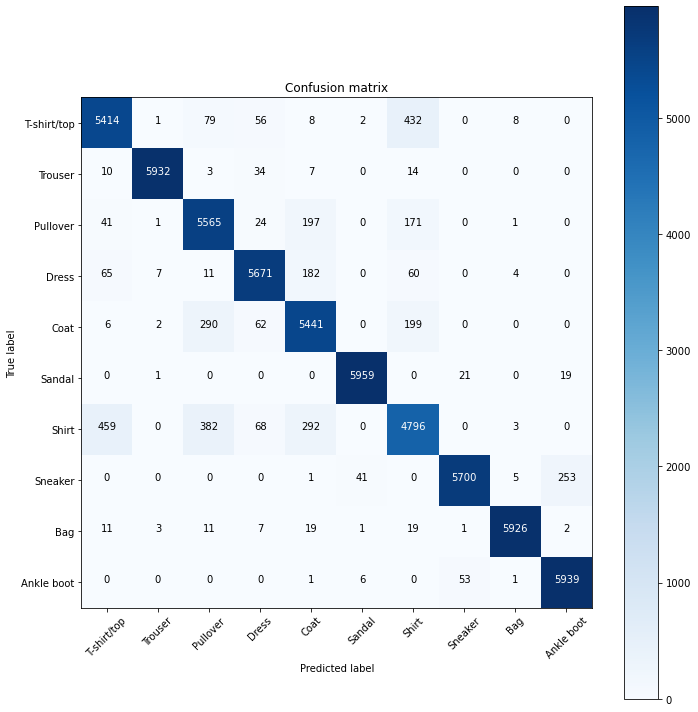

In [19]:
names = tuple(train_set.classes)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cmt, names)